In [125]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from plot_confusion_matrix import plot_confusion_matrix
from torchviz import make_dot
from torchsummary import summary
import torchvision.transforms.functional as TF

In [93]:
import os
os.environ["PATH"] += os.pathsep + 'C:Users/Szymon/anaconda3/envs/ein-zwei-drei/Library/bin/graphviz'

In [94]:
torch.cuda.empty_cache()

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [96]:
convert_input = lambda images : images.view(images.shape[0], -1).to(device)

### Parameters

In [97]:
input_size = 784
num_classes = 10
num_epochs = 100
patience = 10
batch_size = 512
learning_rate = 0.001

### import EarlyStopping

In [98]:
from pytorchtools import EarlyStopping

### MNIST dataset 

In [99]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

In [100]:
train_dataset = torchvision.datasets.MNIST(root='..//set', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

In [101]:
test_dataset = torchvision.datasets.MNIST(root='..///set', 
                                          train=False, 
                                          transform=transform)

In [102]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Fully connected neural network

In [103]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        #layers
        self.l1 = nn.Linear(784, 256) # layer 1
        self.l2 = nn.Linear(256, 128) # layer 2
        self.l3 = nn.Linear(128, 64) # layer 3
        self.l4 = nn.Linear(64, 10) # layer 4
        
        self.sigmoid = nn.Sigmoid() 
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim = 1) 
     
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.sigmoid(x)
        x = self.l4(x)
        x = self.softmax(x)
        return x

In [104]:
model = NeuralNet().to(device)

### Architecture

In [105]:
# x = torch.zeros(1, 1, 784, dtype=torch.float, requires_grad=False).to(device)
# y = model(x).to(device)
# make_dot(y.mean(), params=dict(model.named_parameters()))

In [106]:
# summary(model, (1, 784))

In [107]:
# model = nn.Sequential()
# model.add_module('W0', nn.Linear(8, 16))
# model.add_module('tanh', nn.Tanh())
# model.add_module('W1', nn.Linear(16, 1))

# x = torch.randn(1, 8)
# y = model(x).to(device)

# make_dot(y.mean(), params=dict(model.named_parameters()))

### Loss and optimizer

In [108]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Train the model

In [109]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [110]:
size = len(train_loader.dataset)
print(size)

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=patience, verbose=True)

for epoch in range(num_epochs):
    ##########################    
    #######TRAIN MODEL########
    ##########################
    epochs_loss=0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
#         images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
#         print(images.shape)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        
        #calculate train_loss
        train_losses.append(loss.item())
        optimizer.step()
    
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = numpy.average(train_losses)
    valid_loss = numpy.average(valid_losses)
#     print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = (f'train_loss: {train_loss:.5f} ' + f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)

    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break


60000
train_loss: 1.11408 valid_loss: 0.50727
Validation loss decreased (inf --> 0.507274).  Saving model ...
0
train_loss: 0.38873 valid_loss: 0.30499
Validation loss decreased (0.507274 --> 0.304985).  Saving model ...
1
train_loss: 0.26025 valid_loss: 0.22908
Validation loss decreased (0.304985 --> 0.229081).  Saving model ...
2
train_loss: 0.19281 valid_loss: 0.17513
Validation loss decreased (0.229081 --> 0.175132).  Saving model ...
3
train_loss: 0.15473 valid_loss: 0.15735
Validation loss decreased (0.175132 --> 0.157350).  Saving model ...
4
train_loss: 0.12770 valid_loss: 0.14110
Validation loss decreased (0.157350 --> 0.141100).  Saving model ...
5
train_loss: 0.10633 valid_loss: 0.12407
Validation loss decreased (0.141100 --> 0.124071).  Saving model ...
6
train_loss: 0.09415 valid_loss: 0.10561
Validation loss decreased (0.124071 --> 0.105610).  Saving model ...
7
train_loss: 0.08093 valid_loss: 0.11231
EarlyStopping counter: 1 out of 10
8
train_loss: 0.07193 valid_loss: 0.

In [111]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

### Loss function vs Epoch

In [112]:
print(avg_valid_losses)
print(len(avg_valid_losses))

[0.5072740614414215, 0.30498507246375084, 0.22908129692077636, 0.17513243705034257, 0.1573495639488101, 0.14110005870461464, 0.12407142780721188, 0.10560980699956417, 0.11231330279260873, 0.0963913554791361, 0.08490169625729323, 0.08290875097736716, 0.08289697128348053, 0.08019258668646216, 0.08103630403056741, 0.0811013258062303, 0.09132261304184794, 0.07390748960897327, 0.0745840298011899, 0.08050629757344722, 0.06838340144604445, 0.07400764282792807, 0.07277128021232784, 0.07270168289542198, 0.0683712438447401, 0.06760208229534329, 0.07668940788134933, 0.07351960050873459, 0.0835256404010579, 0.0868241681251675, 0.07511930870823562, 0.09645155328325927, 0.0756511201383546, 0.06900050924159587, 0.0693658899050206, 0.08119866661727429]
36


25


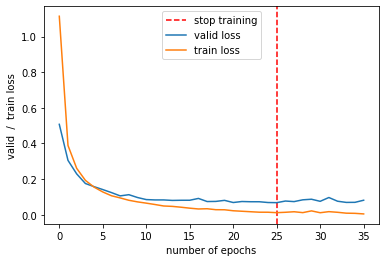

<Figure size 432x288 with 0 Axes>

In [113]:
fig = plt.figure()

######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")

h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)

plt.show()
plt.savefig('./plots/custom_arch1_loss.png')

### Test the model

In [114]:
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'cutom_arch1.ckpt')

Accuracy of the network on the 10000 test images: 98.07 %


### Building confusion matrix

In [115]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [116]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size =10000)
    train_preds = get_all_preds(model, prediction_loader).to(device)
    
train_preds.shape
train_preds.grad_fn
train_preds.grad

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets.to(device) )
print('total correct', preds_correct)
print('accuracy', preds_correct / len(test_dataset))
train_preds.is_cuda

total correct 9807
accuracy 0.9807


True

In [117]:
stacked = torch.stack((test_dataset.targets.to(device), train_preds.argmax(dim=1)), dim=1)
stacked[9].tolist()
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    j,k = p.tolist()
    cmt[j,k] = cmt[j, k] + 1
    
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [118]:
lb = test_dataset.targets.detach().cpu().numpy()

In [119]:
rp = train_preds.argmax(dim=1).detach().cpu().numpy()
print(rp)

[7 2 1 ... 4 5 6]


In [120]:
cm = confusion_matrix(lb, rp)

Confusion matrix, without normalization
[[ 968    0    1    0    1    0    5    1    2    2]
 [   0 1129    2    0    0    0    1    1    2    0]
 [   6    1 1011    3    3    0    2    4    2    0]
 [   0    1    5  982    0    7    0    4    4    7]
 [   0    0    0    0  965    0    6    2    0    9]
 [   3    0    0    4    1  873    5    1    2    3]
 [   4    3    0    0    4    4  942    0    1    0]
 [   0    4   13    3    0    0    0 1003    3    2]
 [   4    0    3    2    3    3    4    2  951    2]
 [   2    2    0    2    7    3    0    6    4  983]]


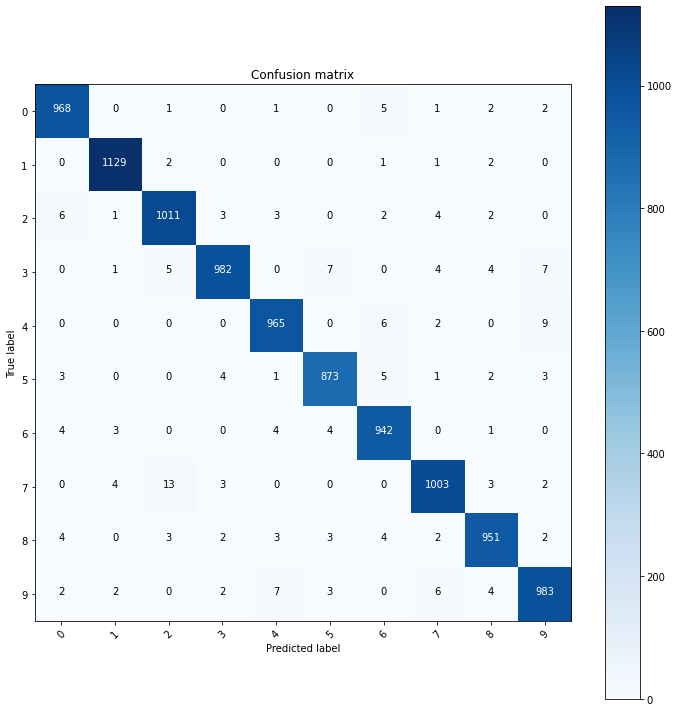

In [121]:
names = set(lb)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

### Image

In [122]:
dataiter = iter(train_loader) # creating a iterator
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    model.predict(images[index]).to(device)
    plt.subplot(6, 10, index)
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

AttributeError: 'NeuralNet' object has no attribute 'predict'

<Figure size 432x288 with 0 Axes>

In [123]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.to(device)
            data = data.reshape(-1,28*28).to(device)
            output = model(data)
            
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
#                 print(wrong_samples[i].shape)
                sample = sample.reshape(28,28).to(device)
                sample = sample * 0.3081
                sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                path = '.\\mistakes\\custom_arch1\\'
                img.save(path+'wrong_idx{}_pred{}_actual{}.png'.format(
                    wrong_idx[i], wrong_pred.item(), actual_pred.item()))

In [126]:
test(model,device, test_loader)